In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist

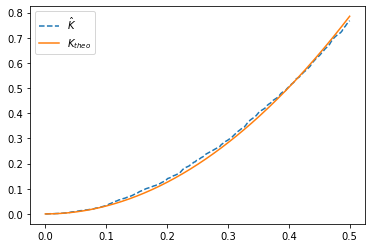

In [2]:
def csr(lam, window=[0, 1, 0, 1]):
    """
    An implementation of the completely spatially random point process in a rectangular region. 
    It returns the $x$- and $y$- coordinates of the simulated points.
    """
    
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min)*(x_max-x_min)
    N = np.random.poisson(lam*area)
    x_list = np.random.uniform(x_min, x_max, N)
    y_list = np.random.uniform(y_min, y_max, N)
    return x_list, y_list

def k_estimate(x, y, window=[0, 1, 0, 1], n=200, r_max=None):
    """
    Estimates the K-function of the input point pattern by Ripley's edge-corrected estimator. 
    It returns an array of values K(r) and the corresponding array of r values.
    """
    
    
    points = np.column_stack((x, y))
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min)*(x_max-x_min)
    N = len(points)
    lam_hat = N/area
    
    u = squareform(pdist(points)) + np.eye(N)
    d1 = np.minimum(x - x_min, x_max - x)
    d2 = np.minimum(y - y_min, y_max - y)
    d1 = np.tile(d1, (N, 1))
    d2 = np.tile(d2, (N, 1))
    d_hypot = np.hypot(d1, d2)
    
    w1 = 1 - 1/np.pi*(np.arccos(np.minimum(d1, u)/u) + np.arccos(np.minimum(d2, u)/u))
    uu = u.copy()
    uu[uu < d_hypot] = d_hypot[uu < d_hypot]
    w2 = 3/4 - 1/(2*np.pi)*(np.arccos(d1/uu) + np.arccos(d2/uu))
    
    d_hypot = np.hypot(d1, d2)
    w_ind = u <= d_hypot
    w = w_ind*w1 + ~w_ind*w2
    u -= np.eye(N)
    
    if not r_max:
        r_max = min(y_max-y_min, x_max-x_min)/2
    
    r = np.linspace(0, r_max, n)
    k = np.zeros(n)
    for i in range(n):
        d_ind = (u < r[i]) & (u > 0)
        k[i] = np.sum((d_ind/w)/N/lam_hat)
    
    return r, k


## Testing
x, y = csr(100) # generate a csr point pattern
r, k = k_estimate(x, y) # estimate the K-function for the point pattern
plt.plot(r, k, ls='--', label=r'$\hat{K}$') # plot
plt.plot(r, np.pi*r**2, label=r'$K_{theo}$')
plt.legend()

In [3]:
def l_estimate(x, y, **kwargs):
    """
    Estimates the $L$-function of the input point pattern by L(r) = \sqrt(K(r)/pi). 
    It returns an array of values L(r) and the corresponding array of r values.
    """
    r, k = k_estimate(x, y, **kwargs)
    l = np.sqrt(k/np.pi)
    return r, l

def sup_L_r(x, y, **kwargs):
    """
    Compute T = sup|L(r) - r| for r < r_max.
    """
    r, l = l_estimate(x, y, **kwargs)
    return abs(max(l - r, key=abs))

def csr_critical_value(x, y, window=[0, 1, 0, 1], alpha=0.05, nsim=99, **kwargs):
    x_min, x_max, y_min, y_max = window
    area = (y_max-y_min) * (x_max-x_min)
    lam_hat = len(x)/area
    
    l_stats = np.zeros(nsim)
    
    for i in range(nsim):
        xx, yy = csr(lam_hat, window=window)
        sup_l = sup_L_r(xx, yy)
        l_stats[i] = sup_l
    
    return np.quantile(l_stats, 1-alpha)

def csr_test(x, y, window=[0, 1, 0, 1], alpha=0.05, nsim=99):
    c = csr_critical_value(x, y, window, alpha, nsim)
    t = sup_L_r(x, y)
    return t < c

## Testing
x, y = csr(100)
csr_test(x, y)

True

In [4]:
def inhibited_process(xmax=1, ymax=1, expectation=100, dist=.05):
    xN, yN = np.random.poisson(expectation*xmax), np.random.poisson(expectation*ymax)
    events = np.c_[np.random.uniform(low=0, high=xmax, size=xN), np.random.uniform(low=0, high=ymax, size=xN)]
    L = len(events)
    D = np.zeros((L, L))
    for i in range(L):
        for j in range(i, L):
            D[i, j] = np.linalg.norm(events[i] - events[j])
    D = D + D.T
    ind = [True] * L
    for i, row in enumerate(D):
        if (row[row>0] < dist).any():
            ind[i] = False
    #print(ind[i])
    #return events, events[ind]
    return events[ind]

In [6]:
power = []
deltas = np.linspace(0.01, 0.035, 9)
print(f'deltas: {deltas}\n')
for delta in deltas:
    print(f'--------delta = {delta}--------')
    results = []
    for i in range(1000):
        if i % 100 == 0:
            print(f'Running simulation {i}...')
        obs = inhibited_process(xmax=1, ymax=1, expectation=100, dist=delta)
        x, y = obs[:,0], obs[:,1]
        results.append(csr_test(x, y))
    p = 1000 - sum(results)
    power.append(p/10)
    print(f'power = {p}/100')

deltas: [0.01     0.013125 0.01625  0.019375 0.0225   0.025625 0.02875  0.031875
 0.035   ]

--------delta = 0.01--------
Running simulation 0...
Running simulation 100...
Running simulation 200...
Running simulation 300...
Running simulation 400...
Running simulation 500...
Running simulation 600...
Running simulation 700...
Running simulation 800...
Running simulation 900...
power = 49/100
--------delta = 0.013125000000000001--------
Running simulation 0...
Running simulation 100...
Running simulation 200...
Running simulation 300...
Running simulation 400...
Running simulation 500...
Running simulation 600...
Running simulation 700...
Running simulation 800...
Running simulation 900...
power = 79/100
--------delta = 0.01625--------
Running simulation 0...
Running simulation 100...
Running simulation 200...
Running simulation 300...
Running simulation 400...
Running simulation 500...
Running simulation 600...
Running simulation 700...
Running simulation 800...
Running simulation 900.

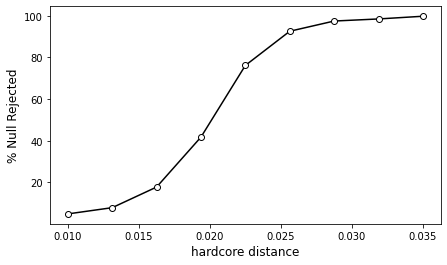

In [7]:
plt.figure(figsize=(7, 4))
plt.plot(deltas, power, marker='o', mfc='white', ls='-', c='k')
plt.xlabel('hardcore distance', fontsize=12)
plt.ylabel('% Null Rejected', fontsize=12)
plt.savefig('power_plot_matI.png', dpi=300, bbox_inches='tight')